### Load Test deployed web application
This notebook pulls some images and tests them against the deployed web application. We submit requests asychronously which should reduce the contribution of latency.

In [1]:
import urllib.request
import matplotlib.pyplot as plt
import aiohttp
import asyncio
import requests
import json
import random
import numpy as np
import testing_utilities
import time
from io import BytesIO
from PIL import Image, ImageOps
from timeit import default_timer
from tqdm import tqdm

%matplotlib inline

In [2]:
print(aiohttp.__version__)  # 2.0.3

2.2.3


We will test our deployed service with 100 calls. We will only have 4 requests concurrently at any time. We have only deployed one pod on one node and increasing the number of concurrent calls does not really increase throughput. Feel free to try different values and see how the service responds.

In [3]:
NUMBER_OF_REQUESTS = 100  # Total number of requests
CONCURRENT_REQUESTS = 4   # Number of requests at a time

Get the IP address of our service

In [4]:
service_json = !kubectl get service azure-dl -o json
service_dict = json.loads(''.join(service_json))
app_url = service_dict['status']['loadBalancer']['ingress'][0]['ip']

In [5]:
scoring_url = 'http://{}/score'.format(app_url)
version_url = 'http://{}/version'.format(app_url)

In [87]:
!curl $version_url # Reports the Tensorflow Version

1.4.1

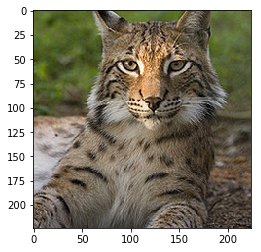

In [75]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"
plt.imshow(testing_utilities.to_img(IMAGEURL))

In [76]:
def gen_variations_of_one_image(num):
    out_images = []
    img = testing_utilities.to_img(IMAGEURL).convert('RGB')
    # Flip the colours for one-pixel
    # "Different Image"
    for i in range(num):
        diff_img = img.copy()
        rndm_pixel_x_y = (random.randint(0, diff_img.size[0]-1), 
                          random.randint(0, diff_img.size[1]-1))
        current_color = diff_img.getpixel(rndm_pixel_x_y)
        diff_img.putpixel(rndm_pixel_x_y, current_color[::-1])
        b64img = testing_utilities.to_base64(diff_img)
        out_images.append(json.dumps({'input':'[\"{0}\"]'.format(b64img)}))
    return out_images

In [77]:
url_list = [[scoring_url, jsonimg] for jsonimg in gen_variations_of_one_image(NUMBER_OF_REQUESTS)]

In [78]:
def decode(result):
    return json.loads(result.decode("utf-8"))

In [79]:
async def fetch(url, session, data, headers):
    start_time = default_timer()
    async with session.request('post', url, data=data, headers=headers) as response:
        resp = await response.read()
        elapsed = default_timer() - start_time
        return resp, elapsed

In [80]:
async def bound_fetch(sem, url, session, data, headers):
    # Getter function with semaphore.
    async with sem:
        return await fetch(url, session, data, headers)

In [81]:
async def await_with_progress(coros):
    results=[]
    for f in tqdm(asyncio.as_completed(coros), total=len(coros)):
        result = await f
        results.append((decode(result[0]),result[1]))
    return results

In [82]:
async def run(url_list, num_concurrent=CONCURRENT_REQUESTS):
    headers = {'content-type': 'application/json'}
    tasks = []
    # create instance of Semaphore
    sem = asyncio.Semaphore(num_concurrent)

    # Create client session that will ensure we dont open new connection
    # per each request.
    async with aiohttp.ClientSession() as session:
        for url, data in url_list:
            # pass Semaphore and session to every POST request
            task = asyncio.ensure_future(bound_fetch(sem, url, session, data, headers))
            tasks.append(task)
        return await await_with_progress(tasks)

Below we run the 100 requests against our deployed service

In [83]:
loop = asyncio.get_event_loop()
start_time = default_timer()
complete_responses = loop.run_until_complete(asyncio.ensure_future(run(url_list, num_concurrent=CONCURRENT_REQUESTS)))
elapsed = default_timer() - start_time
print('Total Elapsed {}'.format(elapsed))
print('Avg time taken {0:4.2f} ms'.format(1000*elapsed/len(url_list)))

100%|██████████| 100/100 [00:05<00:00, 18.33it/s]

Total Elapsed 5.455717712175101
Avg time taken 54.56 ms


Below we can see the output of some of our calls

In [84]:
complete_responses[:3]

[({'result': [[['n02127052 lynx, catamount', 0.9974384307861328],
     ['n02128385 leopard, Panthera pardus', 0.0015150178223848343],
     ['n02128757 snow leopard, ounce, Panthera uncia', 0.0005212018149904907]],
    'Computed in 70.35 ms']},
  0.23767889896407723),
 ({'result': [[['n02127052 lynx, catamount', 0.9974556565284729],
     ['n02128385 leopard, Panthera pardus', 0.0015051687369123101],
     ['n02128757 snow leopard, ounce, Panthera uncia', 0.0005154648097231984]],
    'Computed in 70.01 ms']},
  0.30967544205486774),
 ({'result': [[['n02127052 lynx, catamount', 0.9974404573440552],
     ['n02128385 leopard, Panthera pardus', 0.0015151697443798184],
     ['n02128757 snow leopard, ounce, Panthera uncia', 0.0005185379995964468]],
    'Computed in 69.87 ms']},
  0.38239406095817685)]

In [85]:
num_succesful=[i[0]['result'][0][0][0] for i in complete_responses].count('n02127052 lynx, catamount')
print('Succesful {} out of {}'.format(num_succesful, len(url_list)))

Succesful 100 out of 100


({'result': [[['n02127052 lynx, catamount', 0.9974384307861328],
    ['n02128385 leopard, Panthera pardus', 0.0015150178223848343],
    ['n02128757 snow leopard, ounce, Panthera uncia', 0.0005212018149904907]],
   'Computed in 70.35 ms']},
 0.23767889896407723)

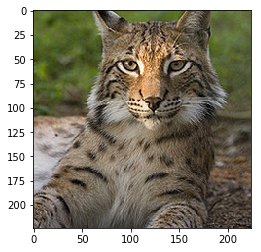

In [86]:
# Example response
plt.imshow(testing_utilities.to_img(IMAGEURL))
complete_responses[0]

To tear down the cluster and all related resources go to the [4th notebook](04_DeployOnAKS.ipynb)